# Vision Transformers
The following networks will be used for musical genre classification. This is because the task of classify all the new music that is released nowadays it is impossible to be done by a human being.

## Libraries

In [1]:
import os
#!pip install opencv-python
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
#!pip install tensorflow-addons
import tensorflow_addons as tfa

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from keras.utils import np_utils
from keras.utils import image_dataset_from_directory
#!pip install vit-keras
from vit_keras import vit, utils, visualize

# Import function to plot the results
import plots

2024-01-11 18:52:58.507741: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/envs/sagemaker-distribution/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Data and parameters

### Data parameters and paths

In [2]:
# Randomize the initial network weights
random_seed = True

# Paths to where training, testing, and validation images are
data_used = 'spectrogram'
database_dir = 'dataset'
train_dir = f'{database_dir}/training/{data_used}'
val_dir = f'{database_dir}/val/{data_used}'
test_dir = f'{database_dir}/test/{data_used}'

# Directory where to store weights of the model and results
root_dir = "results"
# Create root directory for results if it does not exist
if not os.path.exists(root_dir):
    os.makedirs(root_dir)

# Input dimension (number of subjects in our problem)
num_classes = 6

# Name of each gesture of the database
CLASSES = [x for x in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, x))]
print(f'The classes to classify are: {CLASSES}')
#CLASSES = ['Alternative', 'Pop', 'Rock', 'Dance', 'Classical', 'Techno']

# Parameters that characterize the images
img_height = 369
img_width = 496
resize_size = 400
img_channels = 3 # although some images could be rgb, we work with grayscale images
color_mode = 'rgb'

The classes to classify are: ['Alternative', 'Classical', 'Dance', 'Pop', 'Rock', 'Techno']


### Configuration Training Parameters

In [3]:
# Parameters that configures the training process
batch_size = 1  # Batch size
epochs = 5  # Number of epochs
initial_lr = 1e-5   # Learning rate
seed = 42  # Random number
modelRNN = 'ViT'  # RNN model which will be used
version = f'{modelRNN}_BS{batch_size}_E{epochs}_LR{initial_lr}'
experiment_dir = f'{root_dir}/{modelRNN}'

# Create experiment directory if it does not exist
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

# Set random seed
if random_seed:
    seed = np.random.randint(0,2*31-1)
else:
    seed = 5
np.random.seed(seed)
tf.random.set_seed(seed)

### Data Load

In [18]:
# 1. Generate train dataset (ds) from directory of samples
train_ds = image_dataset_from_directory(directory=train_dir,
                                        label_mode = 'int',
                                        class_names=CLASSES,
                                        batch_size=batch_size,
                                        color_mode=color_mode,
                                        image_size=(img_width,img_height), shuffle=True)

# 2. Generate validation dataset (ds) from directory of samples
val_ds  = image_dataset_from_directory(directory=val_dir,
                                       label_mode = 'int',
                                       class_names=CLASSES,
                                       batch_size=batch_size,
                                       color_mode=color_mode,
                                       image_size=(img_width,img_height))

# 3. Generate test dataset (ds) from directory of samples
test_ds = image_dataset_from_directory(directory=test_dir,
                                       label_mode = 'int',
                                       class_names=CLASSES,
                                       batch_size=batch_size,
                                       color_mode=color_mode,
                                       image_size=(img_width,img_height),
                                       shuffle = False)

Found 1187 files belonging to 6 classes.
Found 204 files belonging to 6 classes.
Found 204 files belonging to 6 classes.


### Data Preprocessing
Because Transformers divide the images, it is better to work with square shaped images
1. First the function with the needed transformations is defined
2. The transformations are applied

In [19]:
def preprocess_image(image, resize_size):
    image_np = tf.make_ndarray(tf.make_tensor_proto(image))

    # Transformations which will be applied to each image in the dataset
    resized_image = cv2.resize(image_np[0], (resize_size, resize_size))
    return resized_image

In [20]:
X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

In [21]:
# 1. Training dataset
for image, label in train_ds:
    processed_image = preprocess_image(image, resize_size)
    X_train.append(processed_image)
    y_train.append(label)


# Validation dataset
for image, label in val_ds:
    processed_image = preprocess_image(image, resize_size)
    X_val.append(processed_image)
    y_val.append(label)
    

# Test dataset
for image, label in test_ds:
    processed_image = preprocess_image(image, resize_size)
    X_test.append(processed_image)  # Convert TensorFlow tensor to NumPy array
    y_test.append(label)
    
    
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

X_val = np.array(X_val)
y_val = np.array(y_val)
print(X_val.shape)
print(y_val.shape)

X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape)
print(y_test.shape)

2024-01-11 18:57:57.953172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1187]
	 [[{{node Placeholder/_4}}]]
2024-01-11 18:57:57.953580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1187]
	 [[{{node Placeholder/_0}}]]
2024-01-11 18:58:04.835388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [204]


(1187, 400, 400, 3)
(1187, 1)
(204, 400, 400, 3)
[[2]
 [5]
 [2]
 [4]
 [0]
 [0]
 [5]
 [0]
 [3]
 [0]
 [0]
 [2]
 [1]
 [4]
 [2]
 [4]
 [1]
 [3]
 [1]
 [3]
 [2]
 [0]
 [4]
 [0]
 [4]
 [3]
 [5]
 [4]
 [2]
 [4]
 [1]
 [3]
 [5]
 [0]
 [1]
 [0]
 [4]
 [5]
 [0]
 [5]
 [0]
 [3]
 [0]
 [4]
 [4]
 [5]
 [2]
 [3]
 [3]
 [3]
 [1]
 [5]
 [1]
 [1]
 [5]
 [5]
 [2]
 [3]
 [4]
 [3]
 [0]
 [4]
 [5]
 [5]
 [3]
 [0]
 [2]
 [0]
 [5]
 [5]
 [1]
 [0]
 [2]
 [4]
 [2]
 [5]
 [5]
 [1]
 [2]
 [3]
 [2]
 [2]
 [1]
 [2]
 [0]
 [3]
 [5]
 [0]
 [5]
 [4]
 [4]
 [1]
 [2]
 [5]
 [3]
 [4]
 [5]
 [0]
 [2]
 [2]
 [4]
 [0]
 [2]
 [0]
 [2]
 [5]
 [1]
 [4]
 [4]
 [2]
 [5]
 [2]
 [1]
 [1]
 [1]
 [0]
 [1]
 [4]
 [4]
 [3]
 [1]
 [2]
 [5]
 [4]
 [3]
 [1]
 [2]
 [0]
 [2]
 [1]
 [3]
 [0]
 [1]
 [1]
 [1]
 [3]
 [2]
 [2]
 [1]
 [1]
 [3]
 [0]
 [3]
 [5]
 [3]
 [1]
 [2]
 [1]
 [3]
 [3]
 [3]
 [2]
 [2]
 [1]
 [5]
 [3]
 [0]
 [4]
 [0]
 [1]
 [4]
 [4]
 [0]
 [3]
 [4]
 [4]
 [5]
 [5]
 [2]
 [5]
 [1]
 [0]
 [4]
 [4]
 [5]
 [5]
 [1]
 [0]
 [3]
 [2]
 [5]
 [5]
 [3]
 [4]
 [0]
 [2]
 [4]
 [5]
 [4]
 [1]
 

## Pre-trained model
An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale

### Load the transformer

In [8]:
vit_model = vit.vit_b16(
    image_size=resize_size,
    activation='softmax',
    pretrained=True,
    include_top=True,
    pretrained_top=True
)

vit_model.summary()

/opt/conda/envs/sagemaker-distribution/lib/python3.8/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 25, 25
  warnings.warn(


Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 25, 25, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 625, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 626, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 626, 768)         480768    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 626, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      

### Example of Activation Map

1/1 [==============================] - 5s 5s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


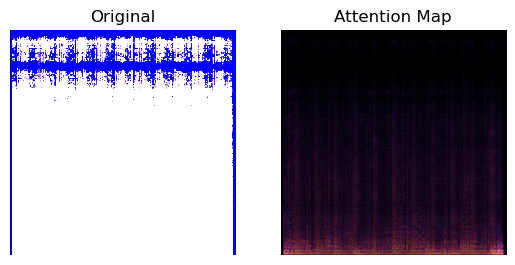

In [9]:
image = X_train[3]

attention_map = visualize.attention_map(model=vit_model, image=image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image, interpolation = 'none')
_ = ax2.imshow(attention_map, interpolation='none')

### Model training
1. Model definition
2. Model callbacks
3. Train

In [10]:
for layer in vit_model.layers[:]:
    layer.trainable = False

model = tf.keras.Sequential([
    vit_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation = tfa.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(num_classes, 'softmax')
],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 1000)              86897128  
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               512512    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 6)          

In [22]:
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = initial_lr)

model.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.3,
                                                 patience = 5,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 20,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

In [23]:
history = model.fit(x = X_train,
                    y = y_train,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

model.save(f'{experiment_dir}/{version}.h5')

Epoch 1/5


2024-01-11 18:58:35.956732: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2279040000 exceeds 10% of free system memory.


 212/1187 [====>.........................] - ETA: 21:00 - loss: 1.7918 - accuracy: 0.1274

KeyboardInterrupt: 

## Training Results
Accuracy and Loss obtained along the training process

In [ ]:
plots.accloss(history, modelRNN, experiment_dir, version)


## Testing
### Model Testing
1. Compute the loss function and accuracy for the test data
2. Confusion Matrix obtained from testing results

In [ ]:
# Evaluate model
scores = model.evaluate(test_ds, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Loss: %.2f" % scores[0])

# Obtain results to present the confusion matrix
prob_class = model.predict(X_test, batch_size=batch_size)
# Classified labels
y_pred = tf.argmax(prob_class, axis=-1)
# Visualize confusion matrix                                           
plots.cm(y_test, y_pred, modelRNN, CLASSES, experiment_dir, version)